# Recreation of Professor Das' Deep Learning Application on the Black-Scholes Model

**Abstract**: This project is conducted by [Juan Diego Herrera](https://github.com/jknaudt21) and [Seungho (Samuel) Lee](https://github.com/samuellee19). Here, we expand upon Robert Culkin's and Sanjiv R. Das' effort to recreate the Black-Scholes option pricing model using neural networks.

[Robert Culkin, Sanjiv R. Das, Machine Learning in Finance: The Case of Deep Learning for Option Pricing (2017)](https://srdas.github.io/Papers/BlackScholesNN.pdf).

## Project Overview
### Background
**The Black Scholes model** is used to price put and call options by estimating the variation over time said financial instruments. The model is based on the assumption that the markets are highly efficient (i.e., Efficient Market Hypothesis), which suggests that stock prices are uncorrelated to one another across time. As a result, Geometric Brownian Motion (GBM) also has been assumed. However, the assumption isoften violated in practice, leading to numerous variations of the Black-Scholes model. 

The **Black-Scholes formula for European call and put options** are:

$$C(S_0,t)=S_0N(d_1)-Ke^{-r(T-t)}N(d_2)$$
$$P(S_0,t)=Ke^{-r(T-t)}N(-d_2)-S_0N(-d_1)$$
where
- $S_0$: Stock Price
- $C(S_0,t)$: Price of the Call Option
- $K$: Exercise Price
- $(T-t)$: Time to Maturity, where T is Exercise Date
- $\sigma$: Underlying Volatility (a standard deviation of log returns)
- $r$: Risk-free Interest Rate (i.e., T-bill Rate)

The $d_i$ variables are defined as:
$$d_1=\frac{\ln\frac{S_0}{K}+(r+\frac{\sigma^2}{2})(T-t)}{\sigma\sqrt{T-t}}$$
$$d_2=d_1-\sigma\sqrt{T-t}=\frac{\ln\frac{S_0}{K}+(r-\frac{\sigma^2}{2})(T-t)}{\sigma\sqrt{T-t}}$$

Finally, $N(x)$ is cumulative distribution function for the standard normal distribution.



### Project Objectives
In this project, we aim to do the following:
1) Recreate Culkin and Das' work\
2) See whether fitted simulated model performs well on actual data \
3) Observe if the model can perform better based on different datasets

## Methodologies
### Data

To recreate Culkin and Das' work we utilized the same simulated data used in the paper to train and validate the neural network. 

Aditionally, we queried UKX options data and the options' underlying stock infromation from Bloomberg (see Bloomberg Query File). We also created another dataset by [scraping](https://github.com/jknaudt21/Option-Scraper-BlackScholes) information for S&P500 companies from Yahoo Finance and AlphaQuery.

#### 1. Culkin and Das (2017)

To train a neural network to learn the call option pricing equation, Culkin and Das (2017) simulated a range of call option prices with ranges of different parameters:

| Parameter              |   Range           |
|:-----------------------|:------------------|
| Stock Price $(S)$      | \\$10 — \\$50     |
| Strike Price $(K)$     |  \\$7 — \\$650    |
| Maturity $(T-t)$       | 1 day to 3 years  |
| Dividend Rate $(q)$    | 0\% — 3\%         |
| Risk Free Rate $(r)$   | 1\% — 3\%         |
| Volatility $(\sigma)$  | 5\% — 90\%        |
| Call Price $(C)$       |  \\$0 — \\$328    |

In total, the dataset contains 300,000 observations.

#### 2. UKX Bloomberg Data

This data is consisted of call options for stocks in the UKX 100 from Bloomberg Terminal. As Bloomberg Terminal has an upper bound for queries, this data only consists of 1600+ observations.

#### 3. S&P 500 Scraped Data

To address a limited number of observations on the above data, we collected additional data through web scraping. Although web data may be imperfect, it can still hold useful information. For this dataset there are 57,000+ observations and we evaluate it separately from the addendum of UKX data.



## The Code
We will be using `scikit-learn`'s prebuilt models to train and the plot our results.

### Colab link to drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
drive

ModuleNotFoundError: No module named 'google.colab'

### Importing all necessary depedencies and setting environment

In [28]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from scipy import stats
import matplotlib
matplotlib.rcParams['figure.dpi'] = 300

Set up the path and unzip the data (if necessary)

In [ ]:
path = '/content/drive/My Drive/DM_FinalProj/'

In [ ]:
# Run once
# !unzip '/content/drive/My Drive/DM_FinalProj/data/BS_data.zip' -d '/content/drive/My Drive/DM_FinalProj/data/'

### Importing and preparing training data

In [2]:
df = pd.read_csv('data/BS_training.csv')
df.head()

,Unnamed: 0,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,0,206.484182,194.386150,1.093151,0.005674,0.862692,0.058898,79.434285
1,1,79.581809,73.926431,0.843836,0.020428,0.759562,0.080634,24.975516
2,2,130.957110,154.101232,1.326027,0.019181,0.606436,0.042031,28.927743
3,3,53.020511,58.598175,0.791781,0.028475,0.572696,0.036566,8.573626
4,4,455.190704,529.570396,0.501370,0.009074,0.090578,0.044426,0.210253


The orginal dataset contains an unecessary index column, so we drop it from the frame

In [4]:
df = df.drop(['Unnamed: 0'], axis= 1)

#### Normalizing the data (as done in Culkin and Das)

Here we take advantage that the Black-Scholes formula is linear homegenous in $C(S,K)$, so we can normalize as follows:

$C(S,K)/K = C(S/K,1)$

In [5]:
df["Stock Price"] = df["Stock Price"]/df["Strike Price"]
df["Call Price"] = df["Call Price"]/df["Strike Price"]
df["Strike Price"] = df["Strike Price"]/df["Strike Price"]
df.head()

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,1.062237,1.0,1.093151,0.005674,0.862692,0.058898,0.408642
1,1.076500,1.0,0.843836,0.020428,0.759562,0.080634,0.337843
2,0.849812,1.0,1.326027,0.019181,0.606436,0.042031,0.187719
3,0.904815,1.0,0.791781,0.028475,0.572696,0.036566,0.146312
4,0.859547,1.0,0.501370,0.009074,0.090578,0.044426,0.000397


### Training the model
To remain as faithful to Culkin and Das, we trained the neural network with the following parameters:
- 4 hidden fully connected layers, each with 100 neurons
- Batch size of 64
- 10 training epochs
- 80-20 train-validation split
- Mean Squared error as loss function

The main difference between our model and the paper's model is that our network uses ReLU as the activation function for every layer, instead of using LeakyReLU, ELU, ReLU, and ELU for the four layers respectively. We also did not employ dropout regularization. Lastly, we opted to use "Adam" as our optimizer rather than stochastic gradient descent.

In [6]:
np.random.seed(32)
X_train, X_test, y_train, y_test = train_test_split(df.drop('Call Price', axis=1), 
                                                    df['Call Price'], test_size=0.2)

mlp = MLPRegressor(hidden_layer_sizes=(100,100,100,100), 
                   solver='adam', shuffle = False, batch_size=64, verbose=True,
                   max_iter= 10
                    ) 

In [7]:
np.random.seed(32)
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.00035527
Iteration 2, loss = 0.00009529
Iteration 3, loss = 0.00006484
Iteration 4, loss = 0.00004754


D:\Programs\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


MLPRegressor(batch_size=64, hidden_layer_sizes=(100, 100, 100, 100),
             max_iter=10, shuffle=False, verbose=True)

Since it is important to save model for reproducability, we will be saving the model in every phase:

In [8]:
# Save First Fitted Model
filename = 'models/BS_model.sav'
pickle.dump(mlp, open(filename, 'wb'))

## Analysis and visualizations 
We start by exploring the most basic performance metric for every regression problem: $R^2$

In [8]:
# Load the model (in case no training is necessary)
filename = 'models/BS_model.sav'
mlp = pickle.load(open(filename, 'rb'))

D:\Programs\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPRegressor from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [9]:
print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

Training set score: 0.999476
Test set score: 0.999474


We can see that the model produced very promising results from the simulated data. While the results show that the algorithm is able to learn option pricing mechanism, we cannot draw any significant conclusion that it can produce meaningful results in real life situation.

We can visualize the succes of the model in the graph below:

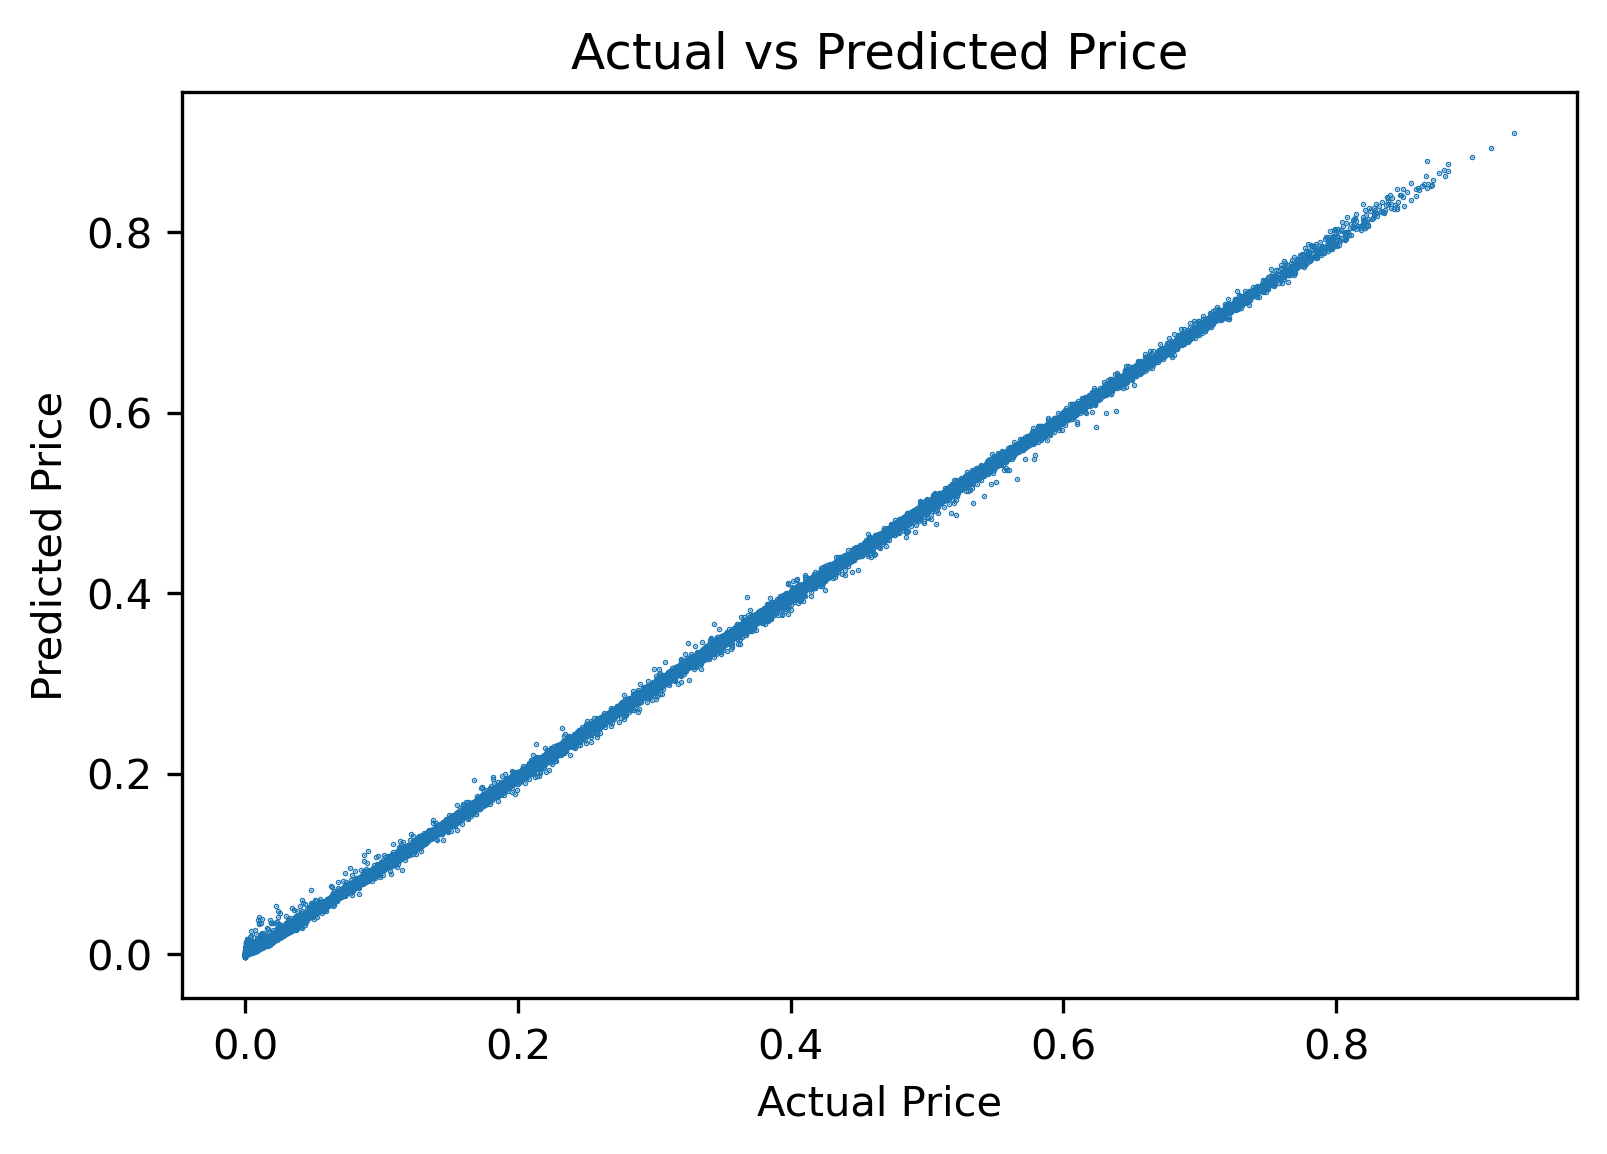

In [10]:
preds_test = mlp.predict(X_test)
plt.scatter(y_test, preds_test, s= 0.1)
plt.ylabel("Predicted Price")
plt.xlabel("Actual Price")
plt.title("Actual vs Predicted Price")
plt.show()

We can also explore the distribution of both the in-sample and out of sample error:

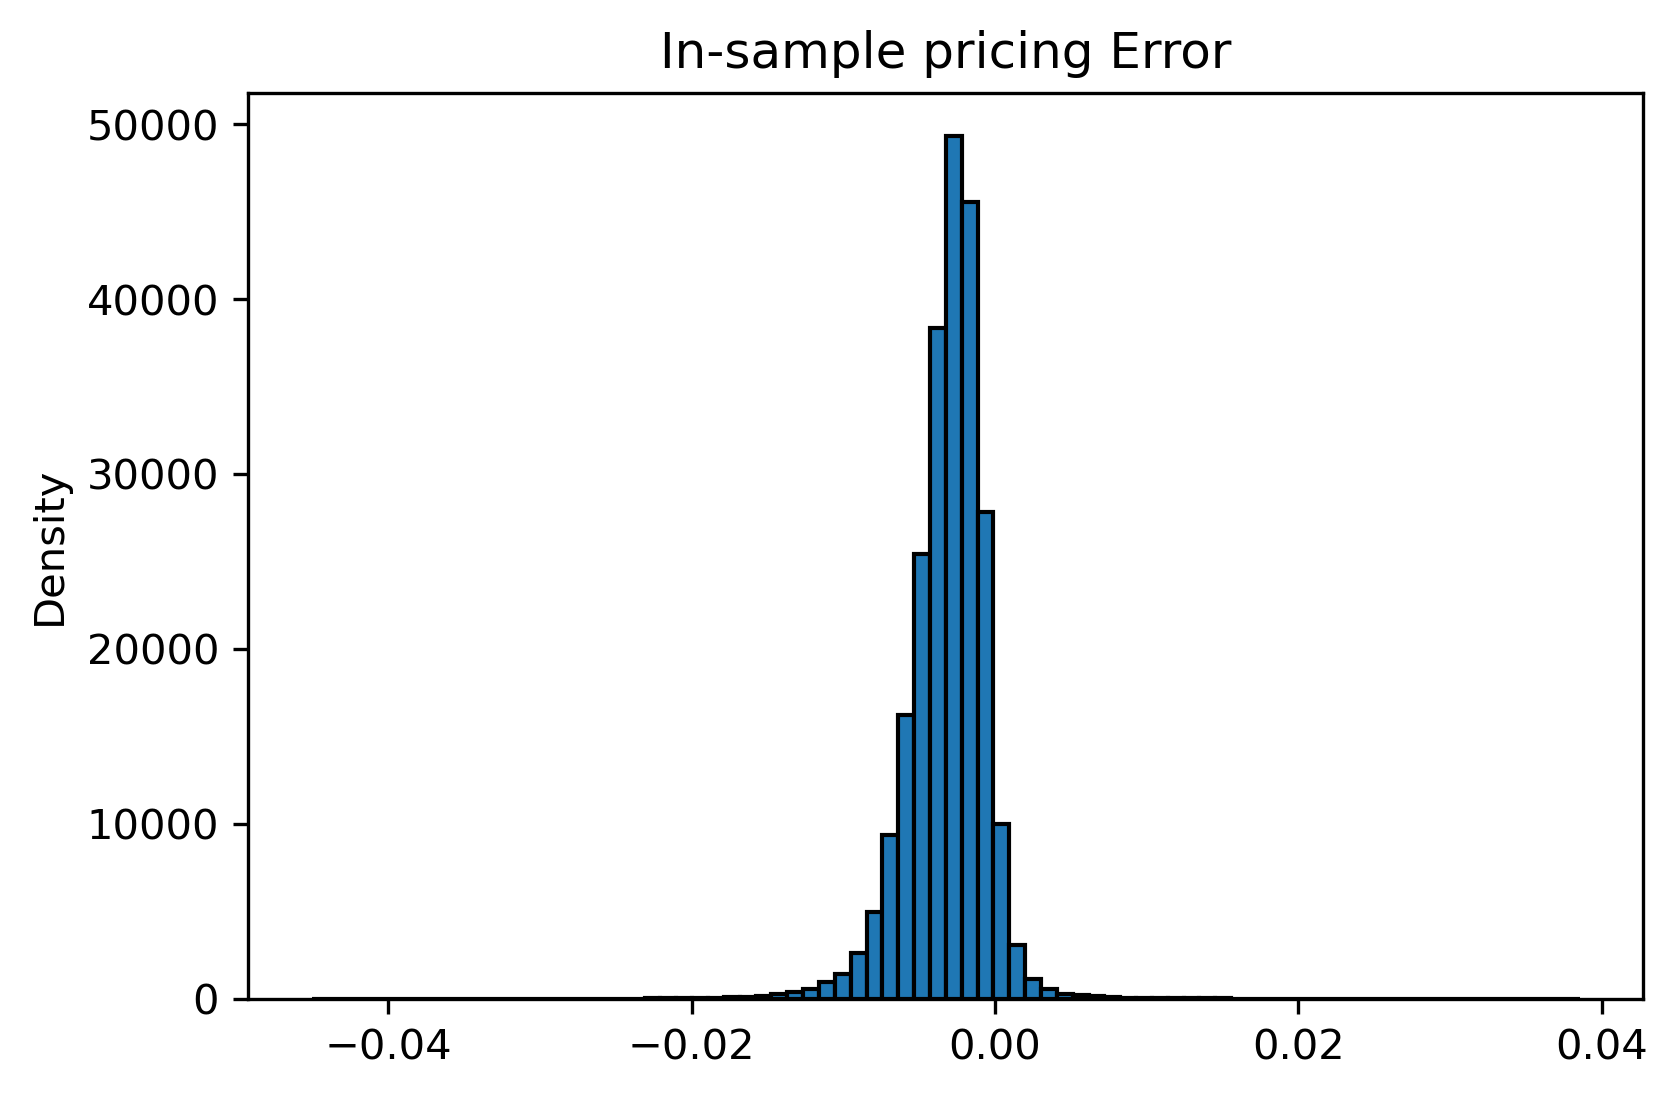

In [11]:
# Panel 1: In-sample Pricing Error
preds_train= mlp.predict(X_train)
pricing_error_train = preds_train - y_train
plt.hist(pricing_error_train, bins= 80, edgecolor='black')
plt.title("In-sample pricing Error")
plt.ylabel("Density")
plt.show()

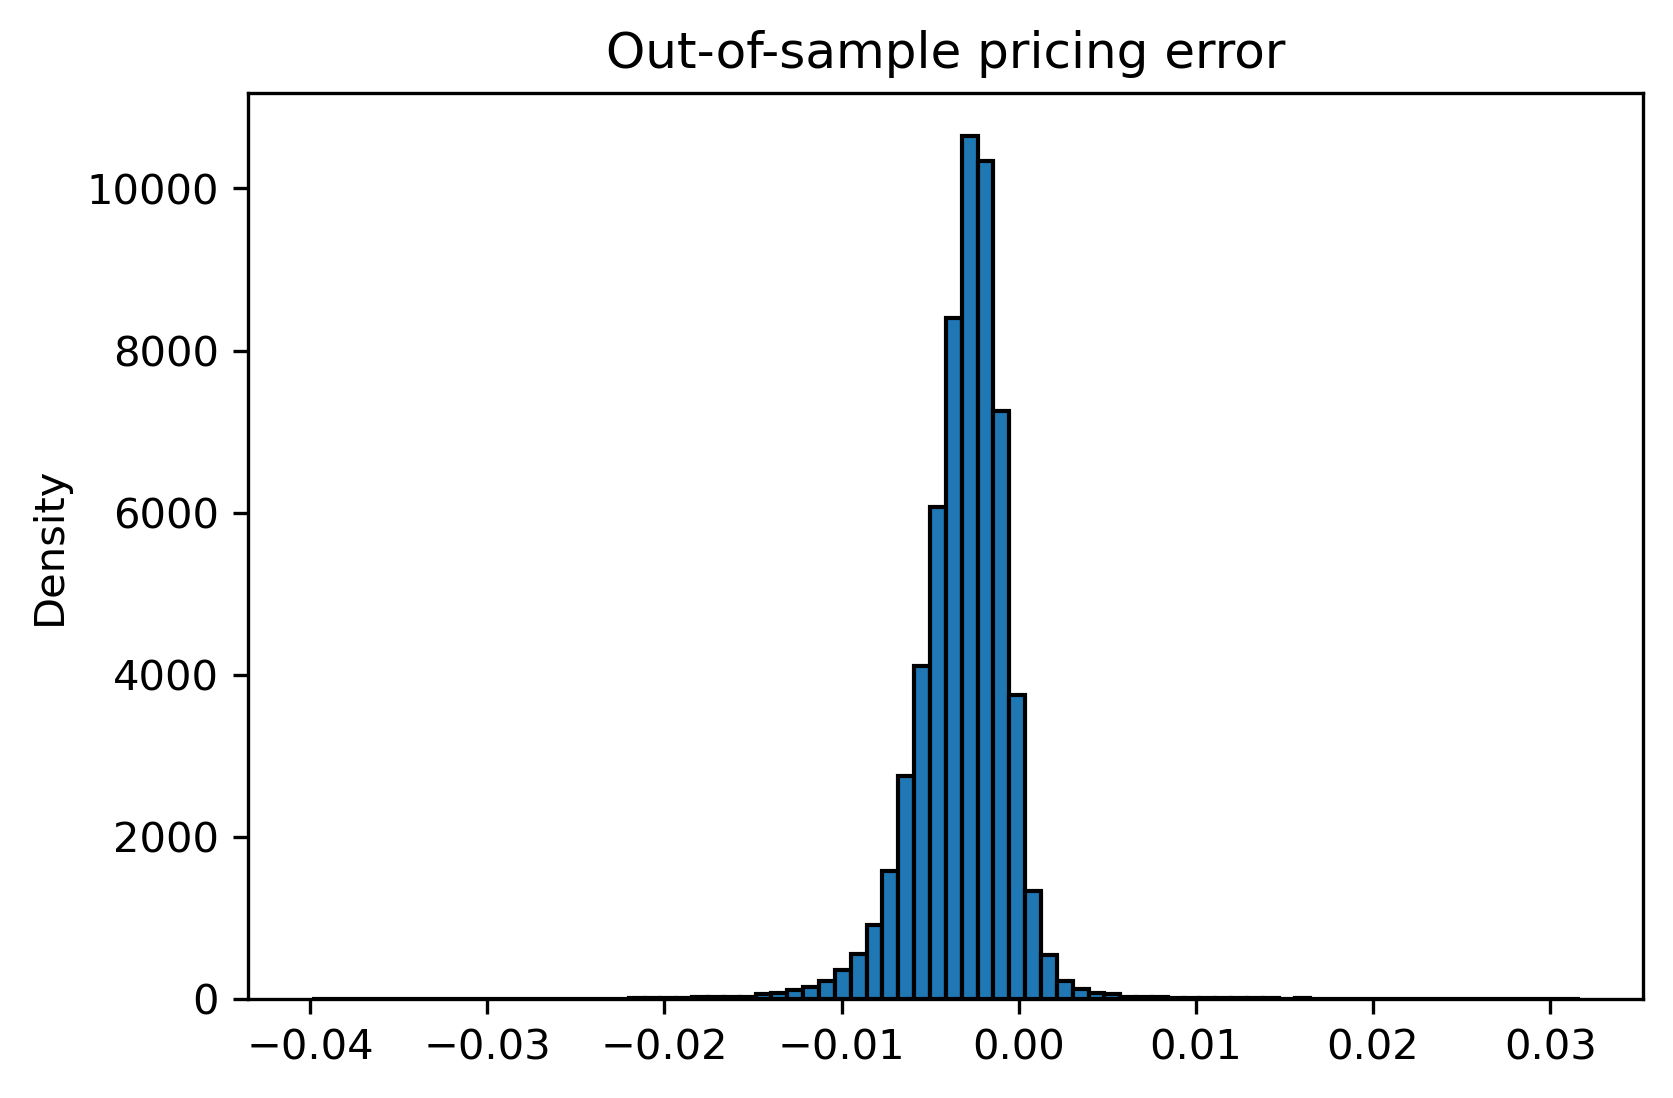

In [12]:
preds_test= mlp.predict(X_test)
pricing_error_test = preds_test - y_test
plt.hist(pricing_error_test, bins= 80, edgecolor='black')
plt.title("Out-of-sample pricing error")
plt.ylabel("Density")
plt.show()

In [13]:
rmse = mean_squared_error(preds_test, y_test)**0.5; rmse # root mean squared error
print("RMSE: %.4f" % rmse)

RMSE: 0.0041


In [14]:
a = pd.DataFrame([stats.describe(pricing_error_train)])
a.style.hide_index().set_table_attributes("style='display:inline'").set_caption('Descriptive Statistics of Pricing Error in Training Set - Simulated')


nobs,minmax,mean,variance,skewness,kurtosis
240000,"(-0.04503973715887655, 0.038556769019683426)",-0.003111,0.000007,-0.400349,12.083641


In [15]:
b = pd.DataFrame([stats.describe(pricing_error_test)])
b.style.hide_index().set_table_attributes("style='display:inline'").set_caption('Descriptive Statistics of Pricing Error in Test Set - Simulated')

nobs,minmax,mean,variance,skewness,kurtosis
60000,"(-0.03991259932903224, 0.031677805872430874)",-0.003110,0.000007,-0.529404,12.293611


## Validating with real data
So far, we have observed the behavior of the model using the synthetic data. Though the use of synthetic data has allowed us to learn the Black-Scholes model quite accurately, we have yet to see how the model performs using real data. Plus, we could also gauge whether models trained in real data are able to better price options in the market.

Nonetheless, it is worth noting that a common option trading strategy is to determine whether an option is undervalued or fairly valued with respect to the market's price and the price outputed by Black-Scholes. With this in mind, if our model misprices an option with a higher price, it could be an indicator that said option is undervalued

**Important**: by the time the data  for this article was collected, the current risk-free rate was 0.88%



### UKX Bloomberg Data
To start the validation, we pulled options data using a Bloomberg terminal. To limit the size of query, we extracted the data for around ~1600 calls on stocks in the UKX100. 



In [16]:
ukx = pd.read_csv('data/UKX_Calls.csv')
ukx= ukx.dropna()
ukx.head()

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,4732.0,1.0,0.09,0.000000,0.392236,0.0088,4731.0
1,4732.0,1.0,0.34,11.949099,0.392236,0.0088,4731.0
2,4732.0,1.0,0.02,0.000000,0.392236,0.0088,4731.0
3,2094.0,1.0,0.09,0.000000,0.529784,0.0088,2093.0
4,2094.0,1.0,0.34,4.424667,0.529784,0.0088,2093.0


Though it might seem that this data is normalized already, such is not the case. Therfore, we normalize the data by dividing by the strike

In [17]:
ukx["Stock Price"] = ukx["Stock Price"]/ukx["Strike Price"]
ukx["Call Price"] = ukx["Call Price"]/ukx["Strike Price"]
ukx["Strike Price"] = ukx["Strike Price"]/ukx["Strike Price"]

We proceeded with dropping `Call Price` column on the data and predicted to see how the model performs.

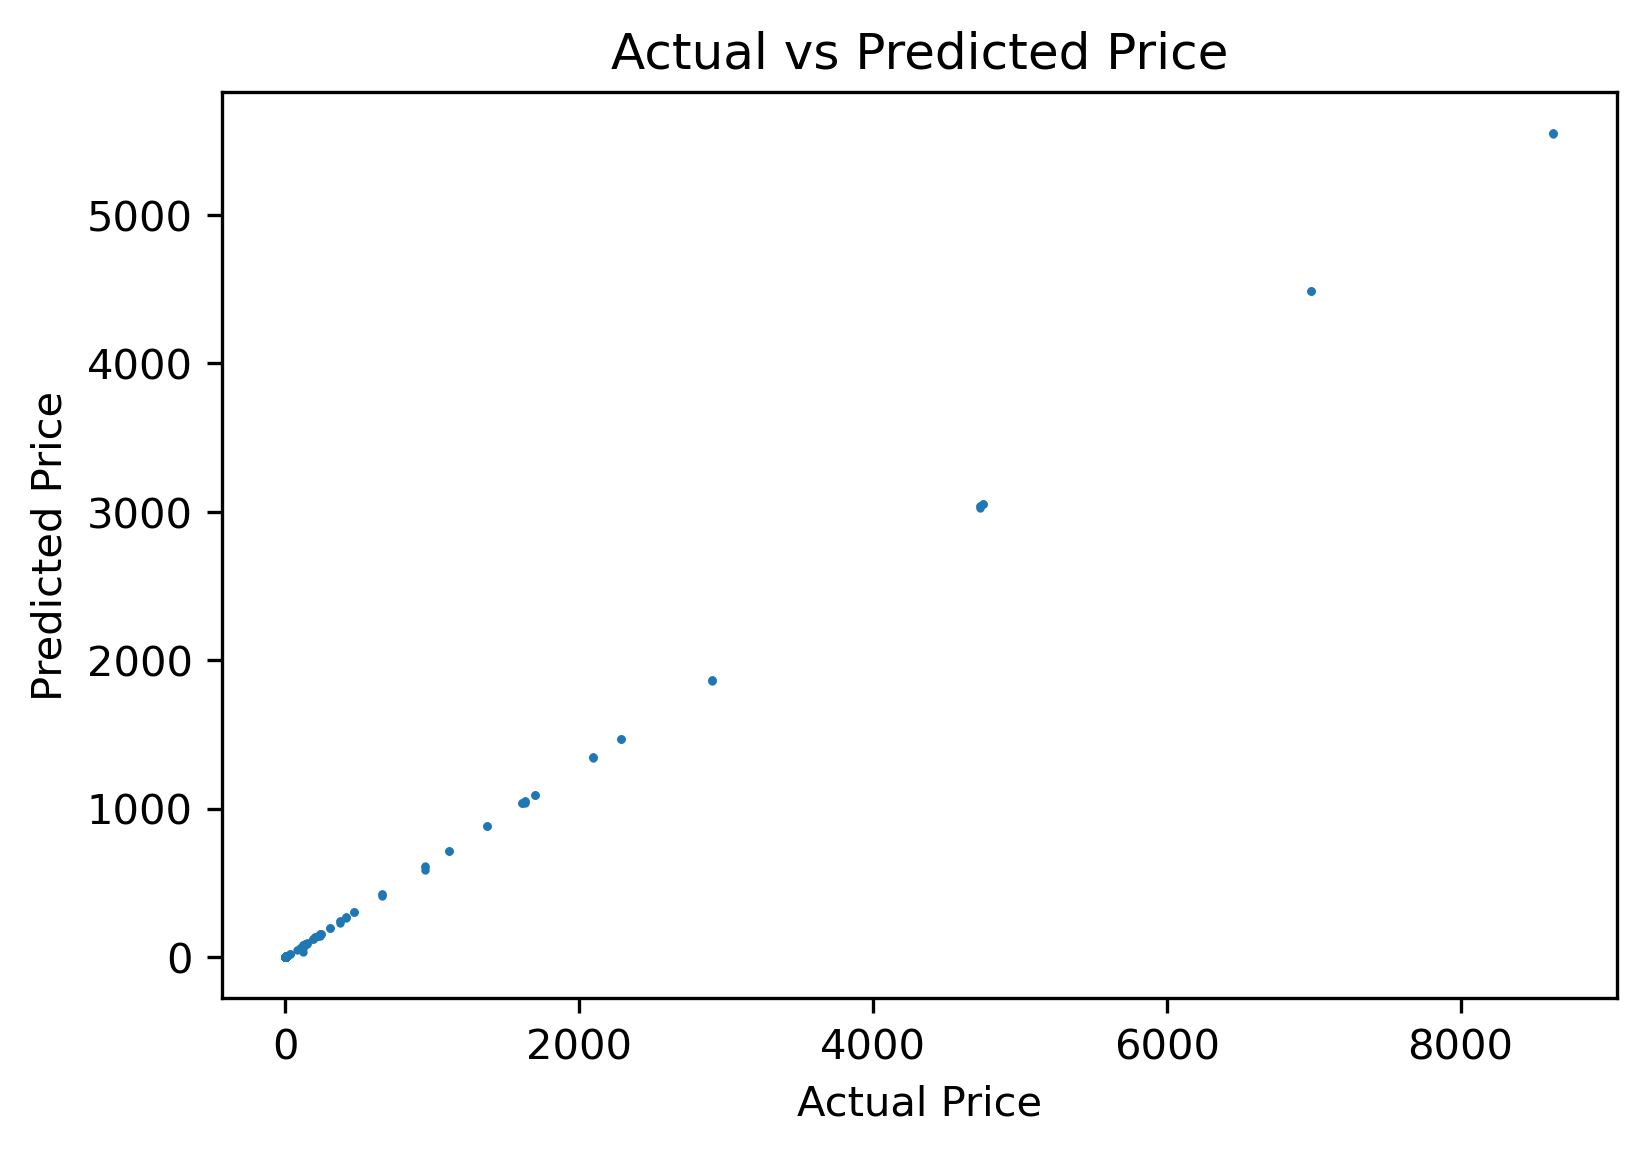

In [18]:
X_ukx = ukx.drop('Call Price', axis=1)
Y_ukx = ukx['Call Price']
preds_ukx= mlp.predict(X_ukx)
plt.scatter(Y_ukx, preds_ukx, s=1)
plt.ylabel("Predicted Price")
plt.xlabel("Actual Price")
plt.title("Actual vs Predicted Price")
plt.show()

From a quick glance, there seems to be some minor deviations. Let's see the $R^2$ for this regression:

In [19]:
print("R-Squared Value: %.4f" % r2_score(Y_ukx, preds_ukx))

R-Squared Value: 0.8699


We can also see the distribution of the errors. Since the simulated data were not generated under a normal distribution, it would not be surprising to observe a skewed distribution:

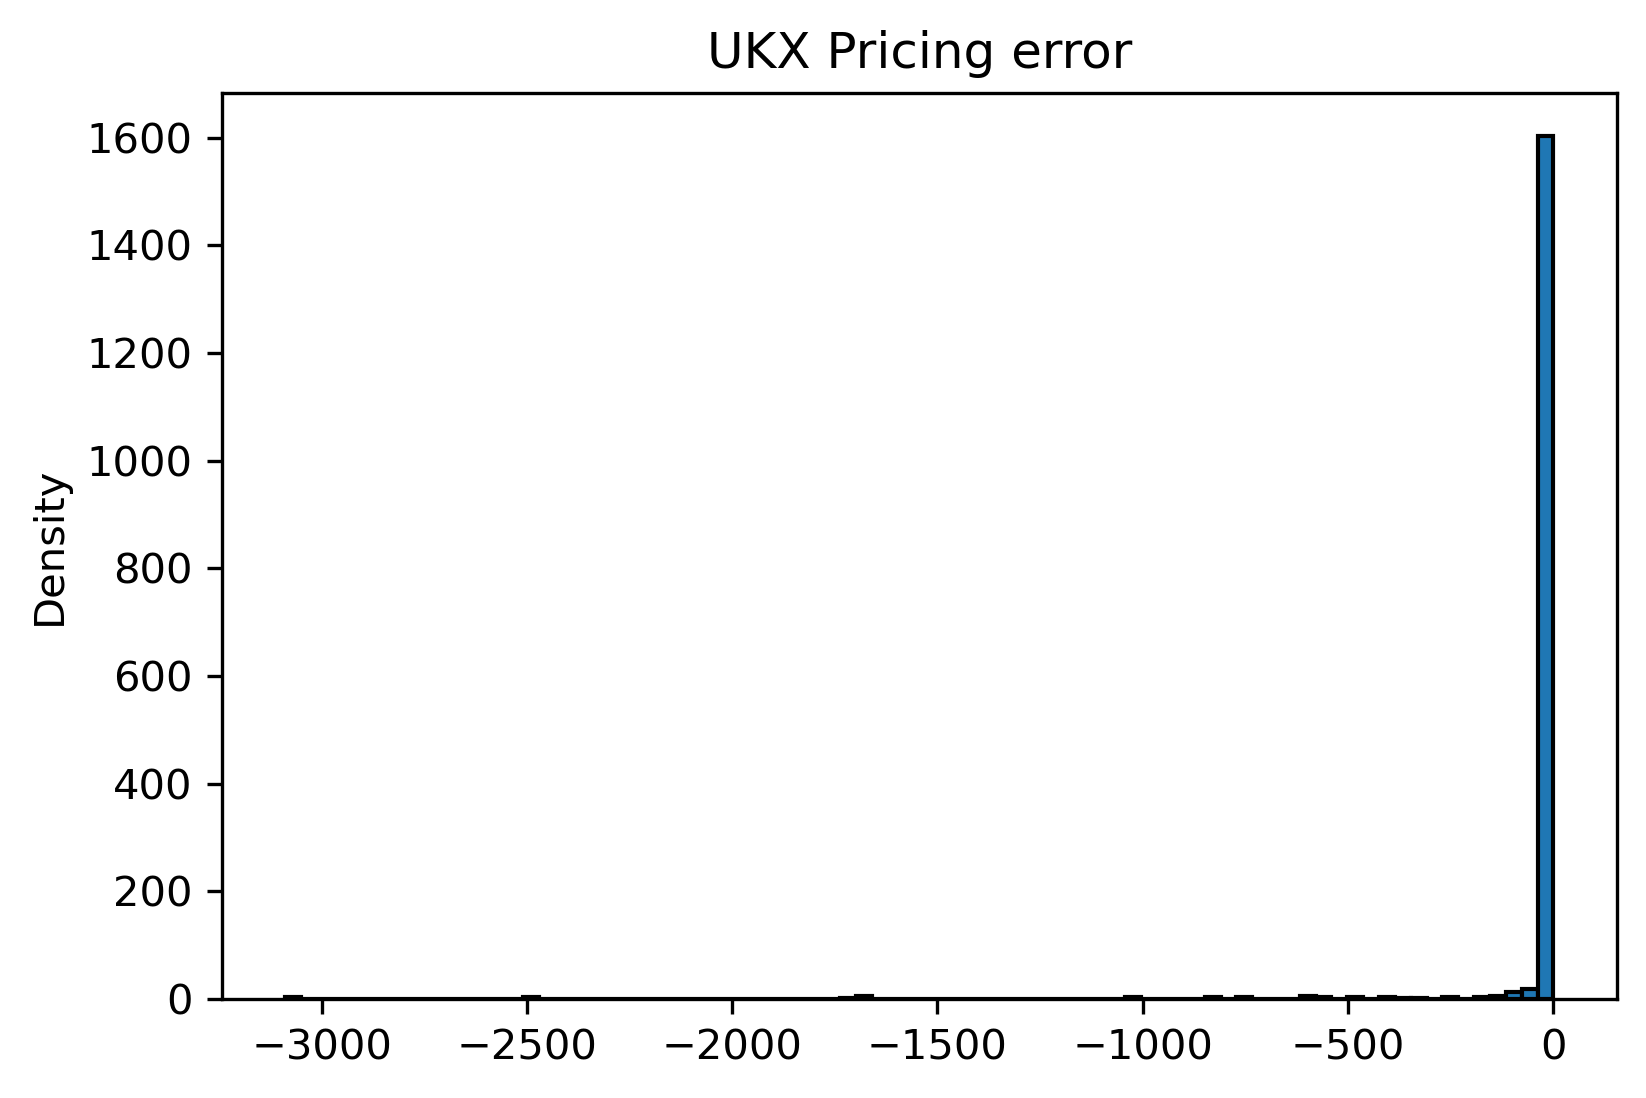

In [20]:
pricing_error_test = preds_ukx - Y_ukx
plt.hist(pricing_error_test, bins= 80, edgecolor='black')
plt.title("UKX Pricing error")
plt.ylabel("Density")
plt.show()

While the model performed worse relative to previous sample, it still achieved a high R-squared value considering that the training data and the test data came from different sources. Hence, the above graph is summarized as below:

In [21]:
a = pd.DataFrame([stats.describe(pricing_error_test)])
a.style.hide_index().set_table_attributes("style='display:inline'").set_caption('Descriptive Statistics: Simulation Model on UKX')

nobs,minmax,mean,variance,skewness,kurtosis
1685,"(-3088.616090144955, 0.35170913484653743)",-28.827895,44608.131476,-10.456920,123.587743


It makes sense that a model trained from the simulated data would perform relatively bad. However, a real question is whether neural network can perform well given real data that is not normally distributed.

To ameliorate the effect of having less data, we increased the number of epochs

In [24]:
np.random.seed(32)
X_train_ukx, X_test_ukx, y_train_ukx, y_test_ukx = train_test_split(ukx.drop('Call Price', axis=1), 
                                                    ukx['Call Price'], test_size=0.2)

In [23]:
mlp_u = MLPRegressor(hidden_layer_sizes=(100,100,100,100), 
                   solver='adam', shuffle = False, batch_size=64, verbose=True,
                   max_iter= 20
                    )

mlp_u.fit(X_train_ukx, y_train_ukx)

filename = 'models/BS_ukx_model.sav'
pickle.dump(mlp_u, open(filename, 'wb'))

Iteration 1, loss = 107663.00309469
Iteration 2, loss = 4354.10833071
Iteration 3, loss = 807.08066007
Iteration 4, loss = 160.66455417
Iteration 5, loss = 14.32174747
Iteration 6, loss = 3.43027232
Iteration 7, loss = 2.30290430
Iteration 8, loss = 1.44645015
Iteration 9, loss = 0.64173072
Iteration 10, loss = 3.23579841


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [22]:
filename = 'models/BS_ukx_model.sav'
mlp_u = pickle.load(open(filename, 'rb'))

D:\Programs\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator MLPRegressor from version 0.23.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [25]:
print("Training Set Score: %f" % mlp_u.score(X_train_ukx, y_train_ukx))
print("Test Set Score: %f" % mlp_u.score(X_test_ukx, y_test_ukx))

Training Set Score: 0.999998
Test Set Score: 0.999998


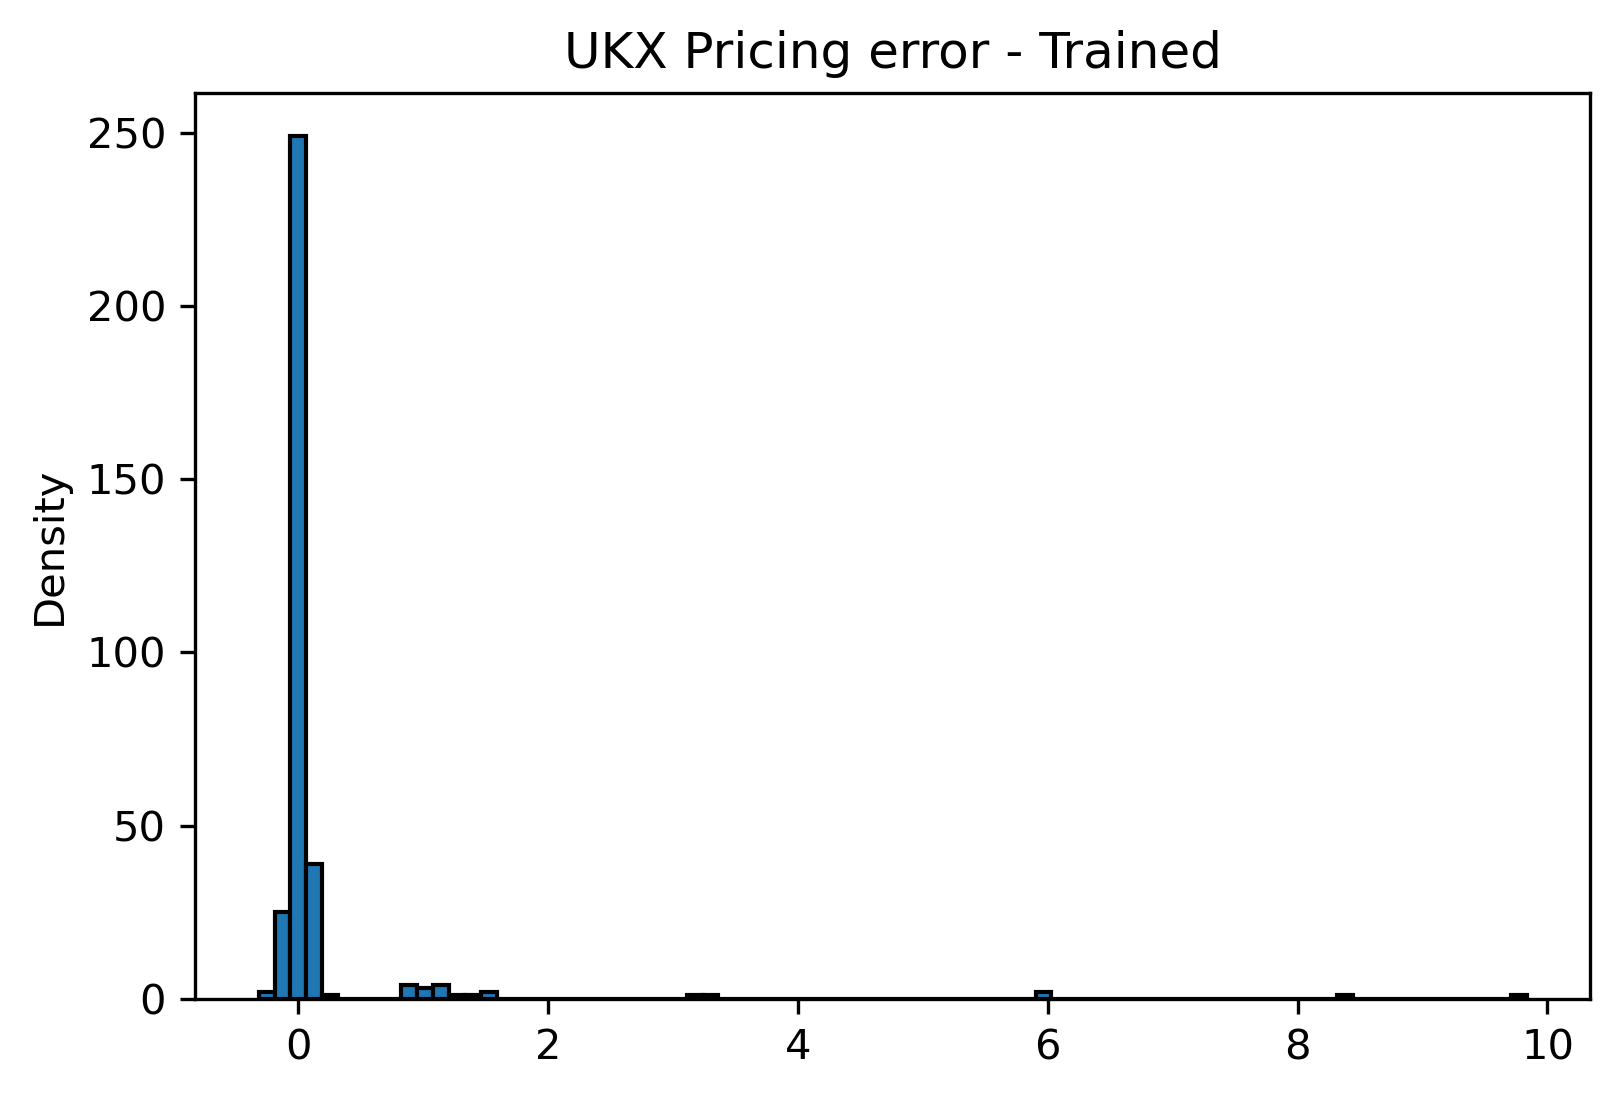

In [29]:
preds_ukx1 = mlp_u.predict(X_test_ukx)
pricing_error_test = preds_ukx1 - y_test_ukx
plt.hist(pricing_error_test, bins= 80, edgecolor='black')
plt.title("UKX Pricing error - Trained")
plt.ylabel("Density")
plt.show()

In [30]:
a = pd.DataFrame([stats.describe(pricing_error_test)])
a.style.hide_index().set_table_attributes("style='display:inline'").set_caption('Descriptive Statistics: UKX Model')

nobs,minmax,mean,variance,skewness,kurtosis
337,"(-0.31623338202718, 9.835618886098018)",0.163965,0.804381,7.900739,69.225675


From the above, we can see that the model was able to perform very well, given that there were only 1,685 observations. However, one thing to note is that the result exhibits a very **high kurtosis**: while the model is consistent in most cases, it could lead to a severe gain/loss (long tails) from time to time. In real-life application, such model will not be preferred by the practitioners as the **expected values of risk associated with investment strategies utilizing the model above will be hard to capture via traditional financial models**, such as Value-at-Risk (VaR).

## S&P500 Scraped Data
To finalize the exploration on the performance of this model, we will see how the model behaves when put it against data scraped from S&P500 options.

To gather the data and generate the dataset, we created [this scraping algorithm](https://github.com/jknaudt21/Option-Scraper-BlackScholes). We made a dataset of ~57,000 entries.

Taking a same approach as the above, we began with a normalization process of the data:



In [31]:
snp = pd.read_csv('data/SNP.csv')
snp= snp.dropna()
snp["Stock Price"] = snp["Stock Price"]/snp["Strike Price"]
snp["Call Price"] = snp["Call Price"]/snp["Strike Price"]
snp["Strike Price"] = snp["Strike Price"]/snp["Strike Price"]
snp.head()

,Stock Price,Strike Price,Maturity,Dividends,Volatility,Risk-free,Call Price
0,21.990000,1.0,0.005616,0.0275,0.3434,0.0088,22.600000
1,4.398000,1.0,0.005616,0.0275,0.3434,0.0088,2.420000
2,3.141429,1.0,0.005616,0.0275,0.3434,0.0088,1.571429
3,2.443333,1.0,0.005616,0.0275,0.3434,0.0088,1.233333
4,2.199000,1.0,0.005616,0.0275,0.3434,0.0088,1.260000


After the normalization, we proceeded with predicting `Call Price` from the S&P data, using an original model:

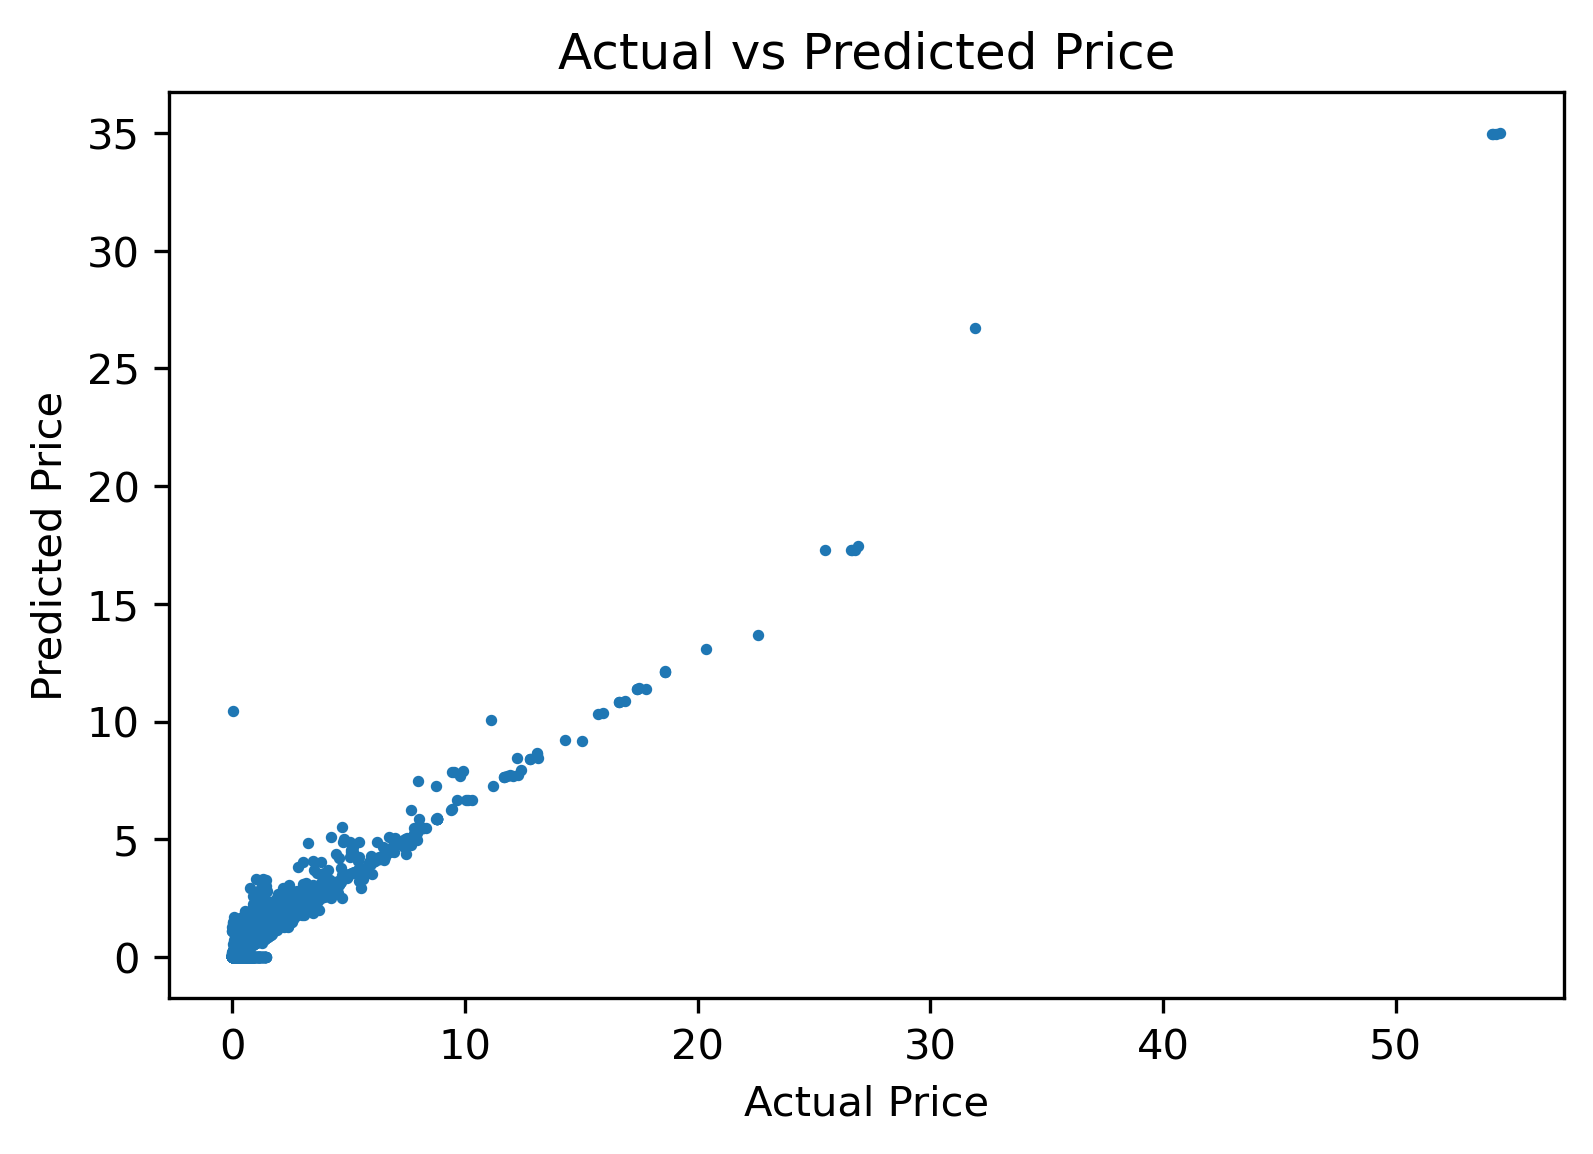

In [32]:
X_snp = snp.drop('Call Price', axis=1)
Y_snp = snp['Call Price']
preds_snp= mlp.predict(X_snp)
plt.scatter(Y_snp, preds_snp, s=3)
plt.ylabel("Predicted Price")
plt.xlabel("Actual Price")
plt.title("Actual vs Predicted Price")
plt.show()

From the above, we can see that there seems to be more deviations than predictions made on previous data. To assess a relationship between the In-The-Money (ITM) call options and the Out-of-The-Money (OTM) call options, we plotted a new graph that is focused on a bottom-left cluster. In the current environment, Black Scholes tends to misprice calls that are both deeply ITM or OTM. For more information about this phenomenon, we suggest to look up information on the [implied volatility smile](https://www.investopedia.com/terms/v/volatilitysmile.asp)

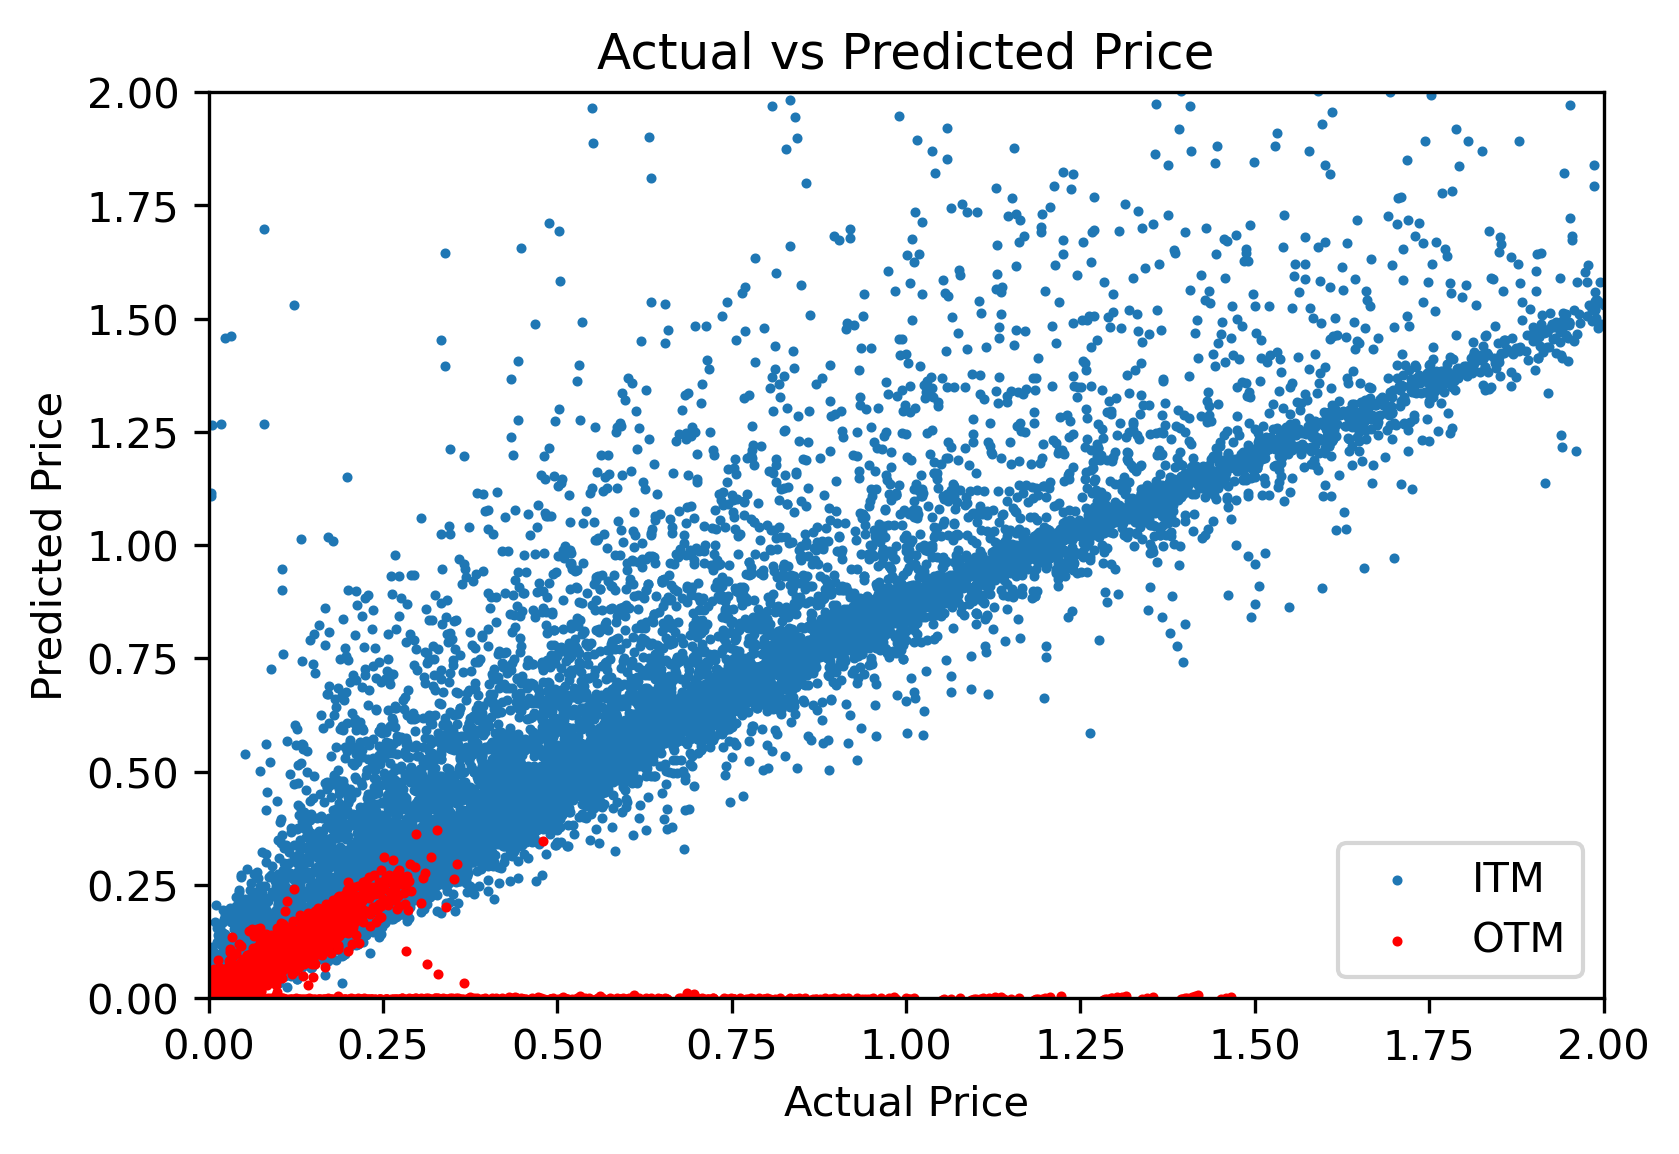

In [35]:
X_snp_itm = snp[snp['Strike Price'] < snp['Stock Price']]
X_snp_otm = snp[snp['Strike Price'] >= snp['Stock Price']] 
Y_snp_itm = X_snp_itm['Call Price']
Y_snp_otm = X_snp_otm['Call Price']
plt.scatter(Y_snp_itm, mlp.predict(X_snp_itm.drop('Call Price', axis=1)), s=2)
plt.scatter(Y_snp_otm, mlp.predict(X_snp_otm.drop('Call Price', axis=1)), c='r', s=2)
plt.ylabel("Predicted Price")
plt.xlabel("Actual Price")
plt.title("Actual vs Predicted Price")
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.legend(['ITM', 'OTM'])
plt.show()

The above graph exhibits what we have discussed in the above. Furthermore, while a variation is relatively higher, the model seems to find some success. In fact, we can see that $R^2$ value is:

In [31]:
print("R-Squared Value: %.4f" %r2_score(Y_snp, preds_snp))

R-Squared Value: 0.8818


The results are outstandingly similar to the UKX. This is indicative that the model might be missing feature data to increase accuracy. Regardless, an $R^2$ of 88% is still impressive as it is hard to capture a high $R^2$ value using real data and traditional financial economic models.

Lastly, we observed a distribution of the pricing errors:

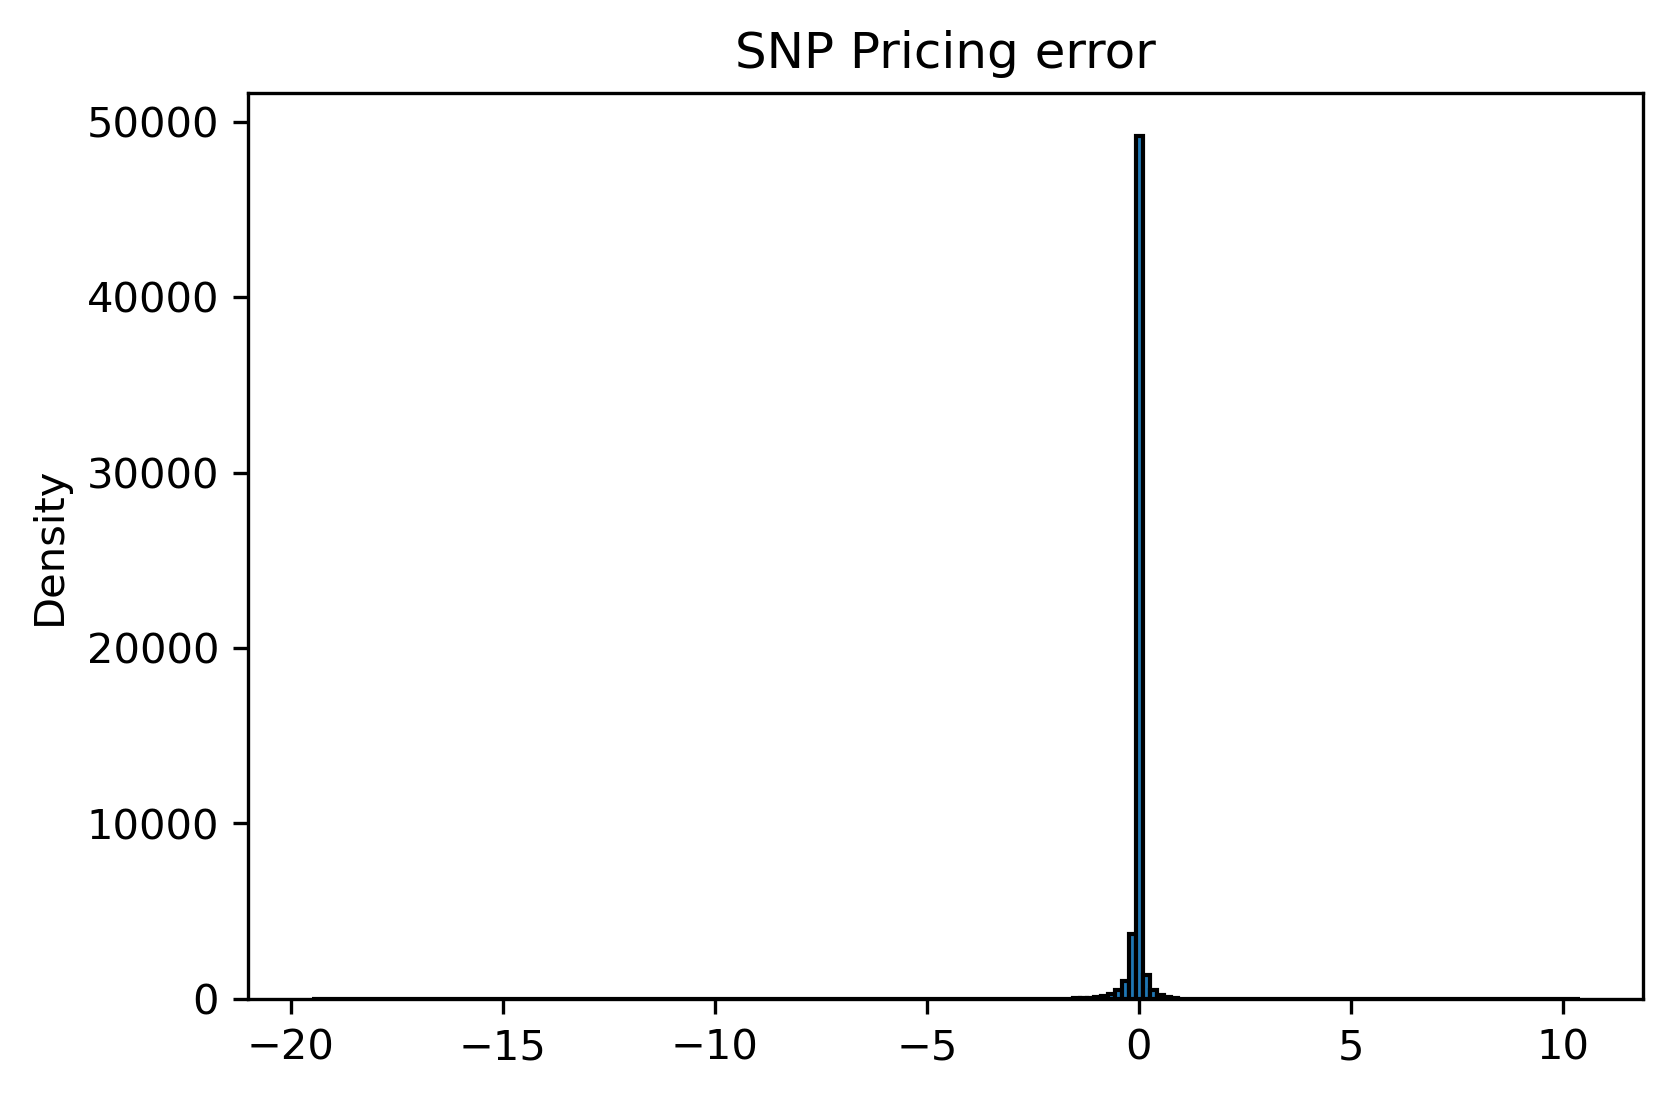

In [58]:
pricing_error_test = preds_snp - Y_snp
plt.hist(pricing_error_test, bins= 180, edgecolor='black')
plt.title("SNP Pricing error")
plt.ylabel("Density")
plt.show()

In [34]:
a = pd.DataFrame([stats.describe(pricing_error_test)])
a.style.hide_index().set_table_attributes("style='display:inline'").set_caption('Descriptive Statistics: Simulation Model on S&P')

nobs,minmax,mean,variance,skewness,kurtosis
57516,"(-19.508911166938113, 10.407229411379921)",-0.030951,0.079653,-29.560814,1739.708145


Due to a presence of extreme values on both tails, the distribution shows high skewness and kurtosis. However, it also exhibits considerably low variance, suggesting that the model predicted fairly accurately, except for some extreme cases.

## Training with real data
In this section, we checked whether a model trained on real data performs significantly better than a model trained on the synthetic data. For this analysis we concatenated the `UKX` and `SNP` data into a larger dataset.

To compensate for a lack of data, we trained the model longer by increasing the number of epochs.

In [37]:
np.random.seed(32)
df2 = pd.concat([ukx, snp])
X_train2, X_test2, y_train2, y_test2 = train_test_split(df2.drop('Call Price', axis=1), 
                                                    df2['Call Price'], test_size=0.2)

In [48]:
mlp2 = MLPRegressor(hidden_layer_sizes=(100,100,100,100), 
                   solver='adam', shuffle = False, batch_size=64, verbose=False,
                   max_iter= 20
                    ) 

mlp2.fit(X_train2, y_train2)

filename = 'models/BS_final_model.sav'
pickle.dump(mlp2, open(filename, 'wb'))

D:\Programs\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [49]:
mlp2 = pickle.load(open(filename, 'rb'))

In [51]:
print("Training set score: %f" % mlp2.score(X_train2, y_train2))
print("Test set score: %f" % mlp2.score(X_test2, y_test2))

Training set score: 0.999941
Test set score: 0.999943


Surprisingly, we observed from the above that there was an insignificant difference in a performance between the two models. Furthermore, we analyzed the pricing error of the real data model:

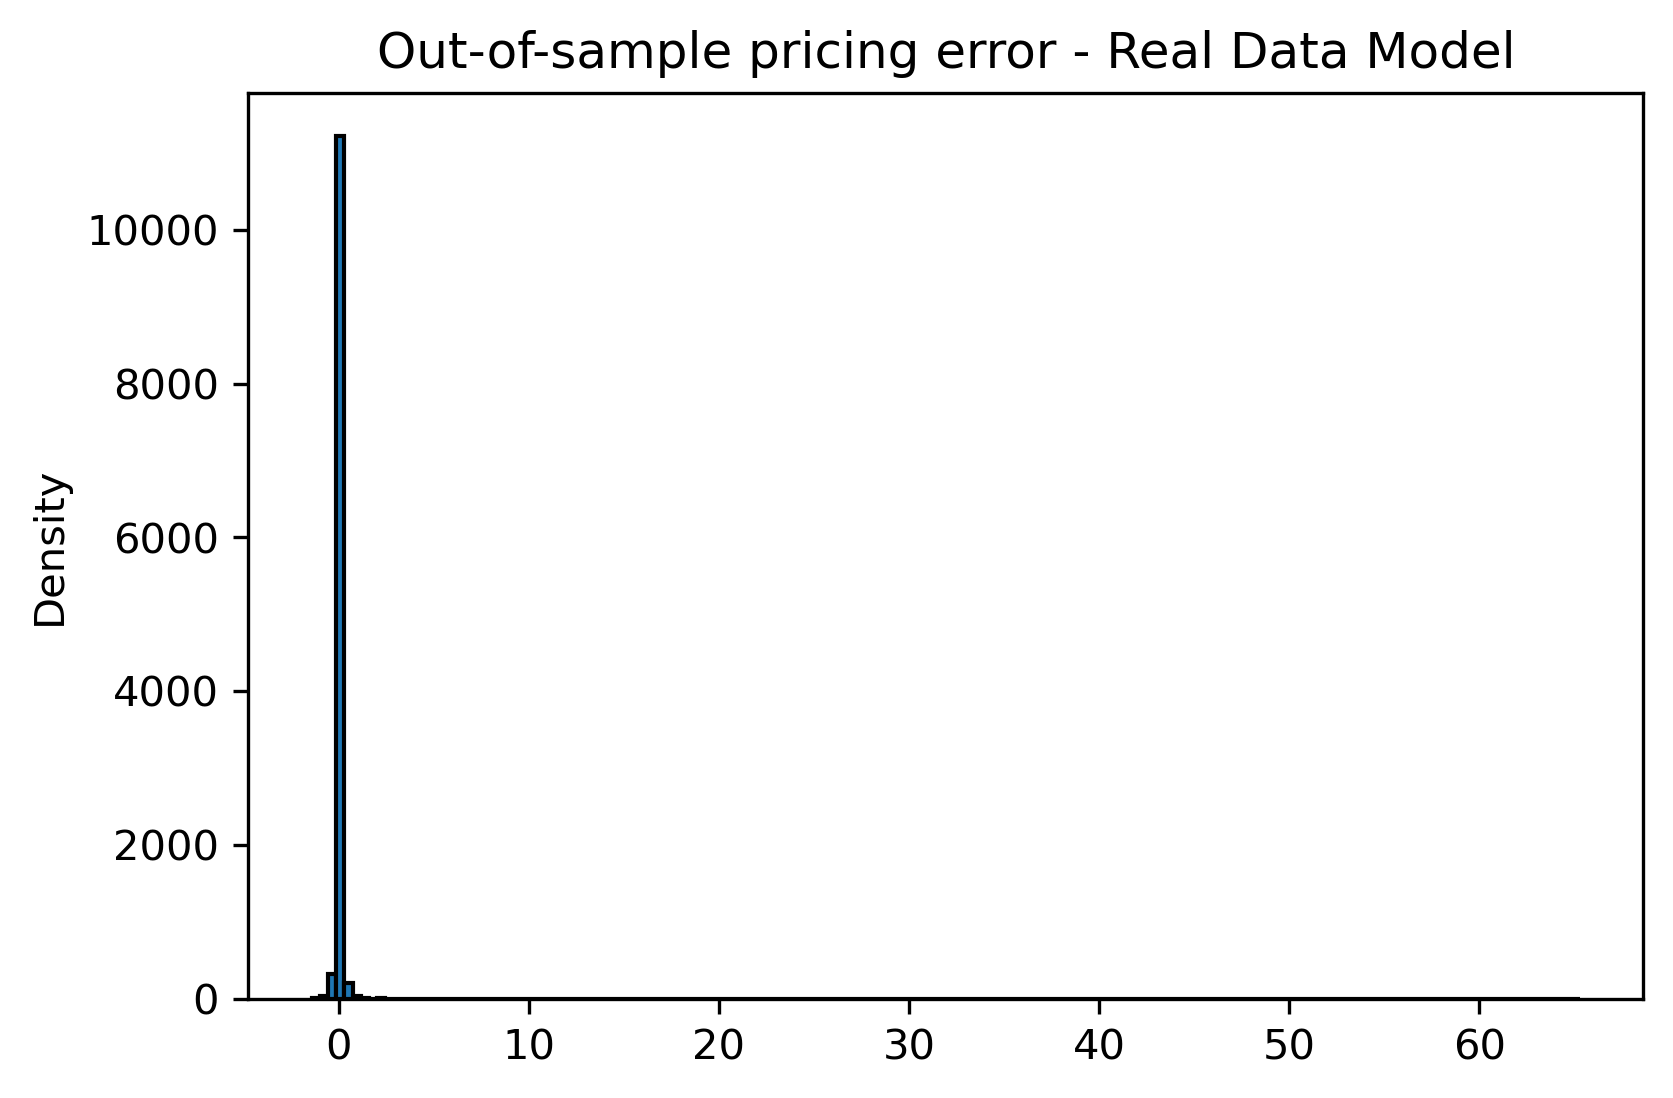

In [52]:
preds_test= mlp2.predict(X_test2)
pricing_error_test = preds_test - y_test2
plt.hist(pricing_error_test, bins= 155, edgecolor='black')
plt.title("Out-of-sample pricing error - Real Data Model")
plt.ylabel("Density")
plt.show()

In [53]:
a = pd.DataFrame([stats.describe(pricing_error_test)])
a.style.hide_index().set_table_attributes("style='display:inline'").set_caption('Descriptive Statistics: Real Data Error')

nobs,minmax,mean,variance,skewness,kurtosis
11841,"(-1.4149300780995988, 65.29475394211659)",0.041074,1.112086,53.563095,3044.092604


We observe a similar distribution as before, even if a few outliers are cropped out.

Finally, for an icing on the cake, we applied the final model on the **simulation data**.

In [54]:
preds_synthetic= mlp2.predict(X_test)
print("R-Squared Value: %.4f" % r2_score(y_test, preds_synthetic))

R-Squared Value: 0.7786


We observed that the model performed slightly weaker, a smiliar result that we had seen from the above predictions. 

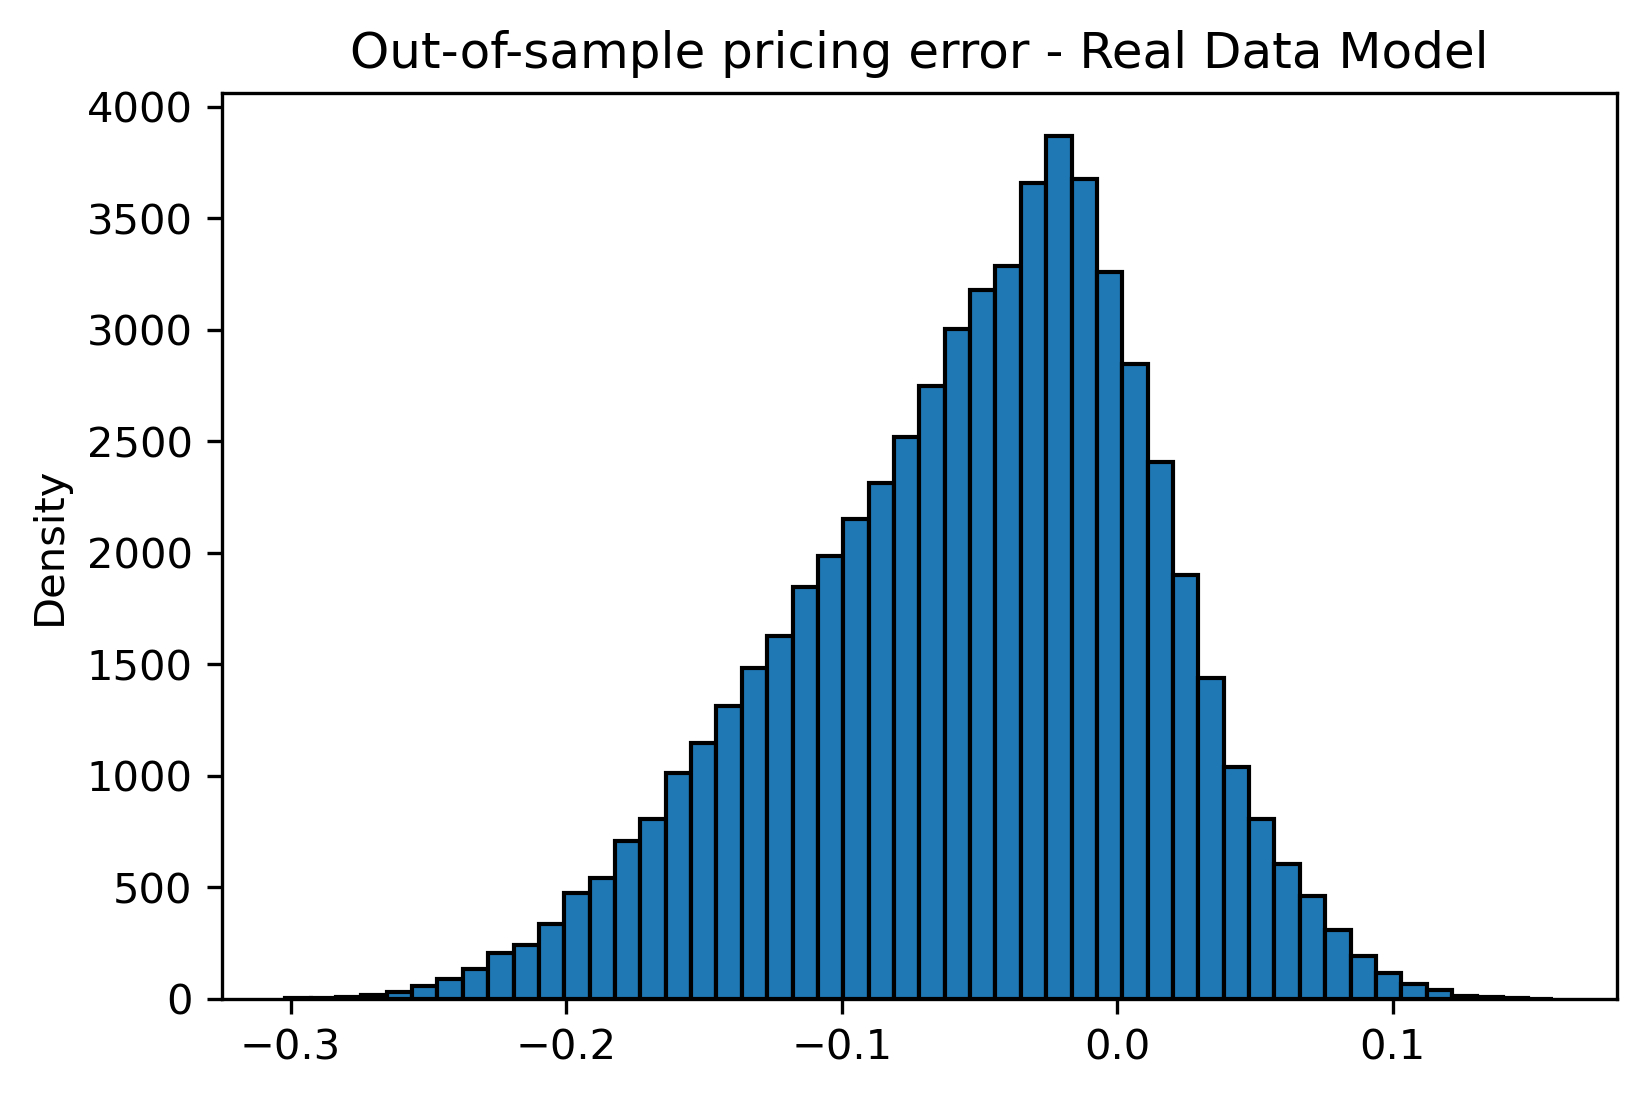

In [55]:
pricing_error_synthetic = preds_synthetic - y_test
plt.hist(pricing_error_synthetic, bins= 50, edgecolor='black')
plt.title("Out-of-sample pricing error - Real Data Model")
plt.ylabel("Density")
plt.show()

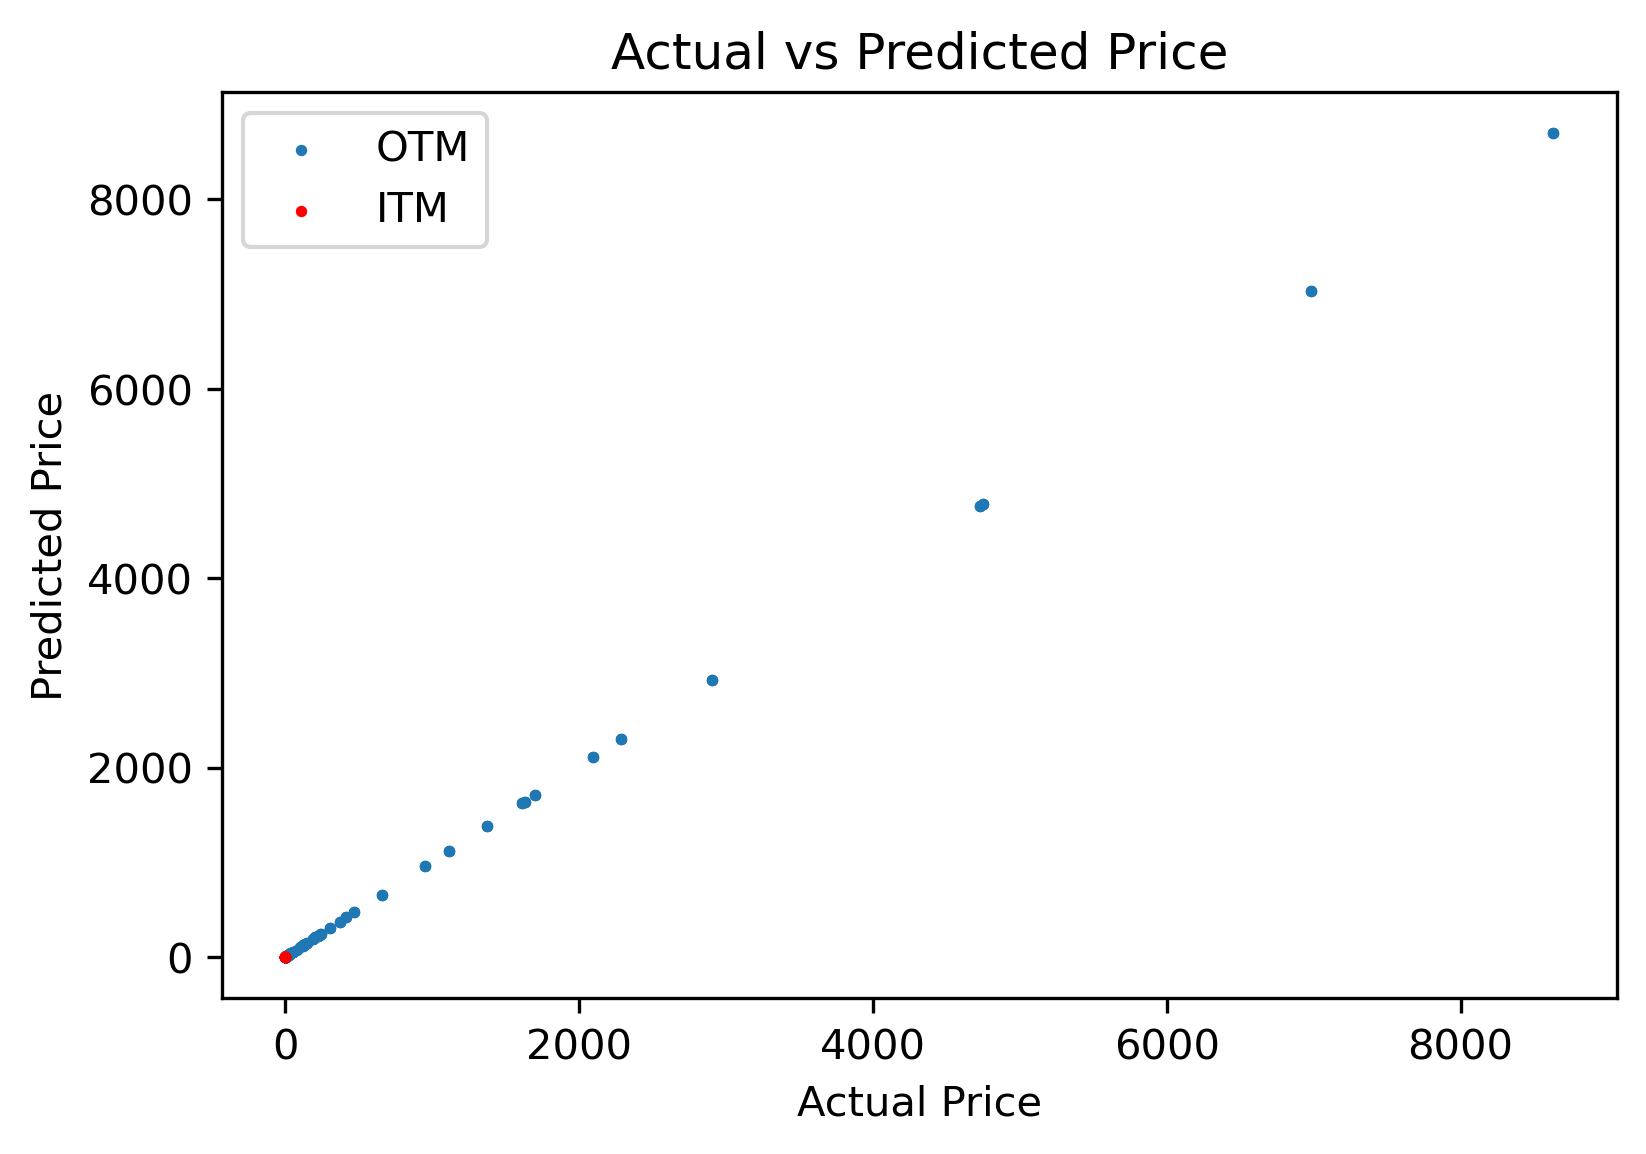

In [58]:
X_df2_itm = df2[df2['Strike Price'] < df2['Stock Price']]
X_df2_otm = df2[df2['Strike Price'] >= df2['Stock Price']] 
Y_df2_itm = X_df2_itm['Call Price']
Y_df2_otm = X_df2_otm['Call Price']
plt.scatter(Y_df2_itm, mlp2.predict(X_df2_itm.drop('Call Price', axis=1)), s=3)
plt.scatter(Y_df2_otm, mlp2.predict(X_df2_otm.drop('Call Price', axis=1)), c='r', s=3)
plt.ylabel("Predicted Price")
plt.xlabel("Actual Price")
plt.title("Actual vs Predicted Price")
plt.legend(['OTM', 'ITM'])
plt.show()

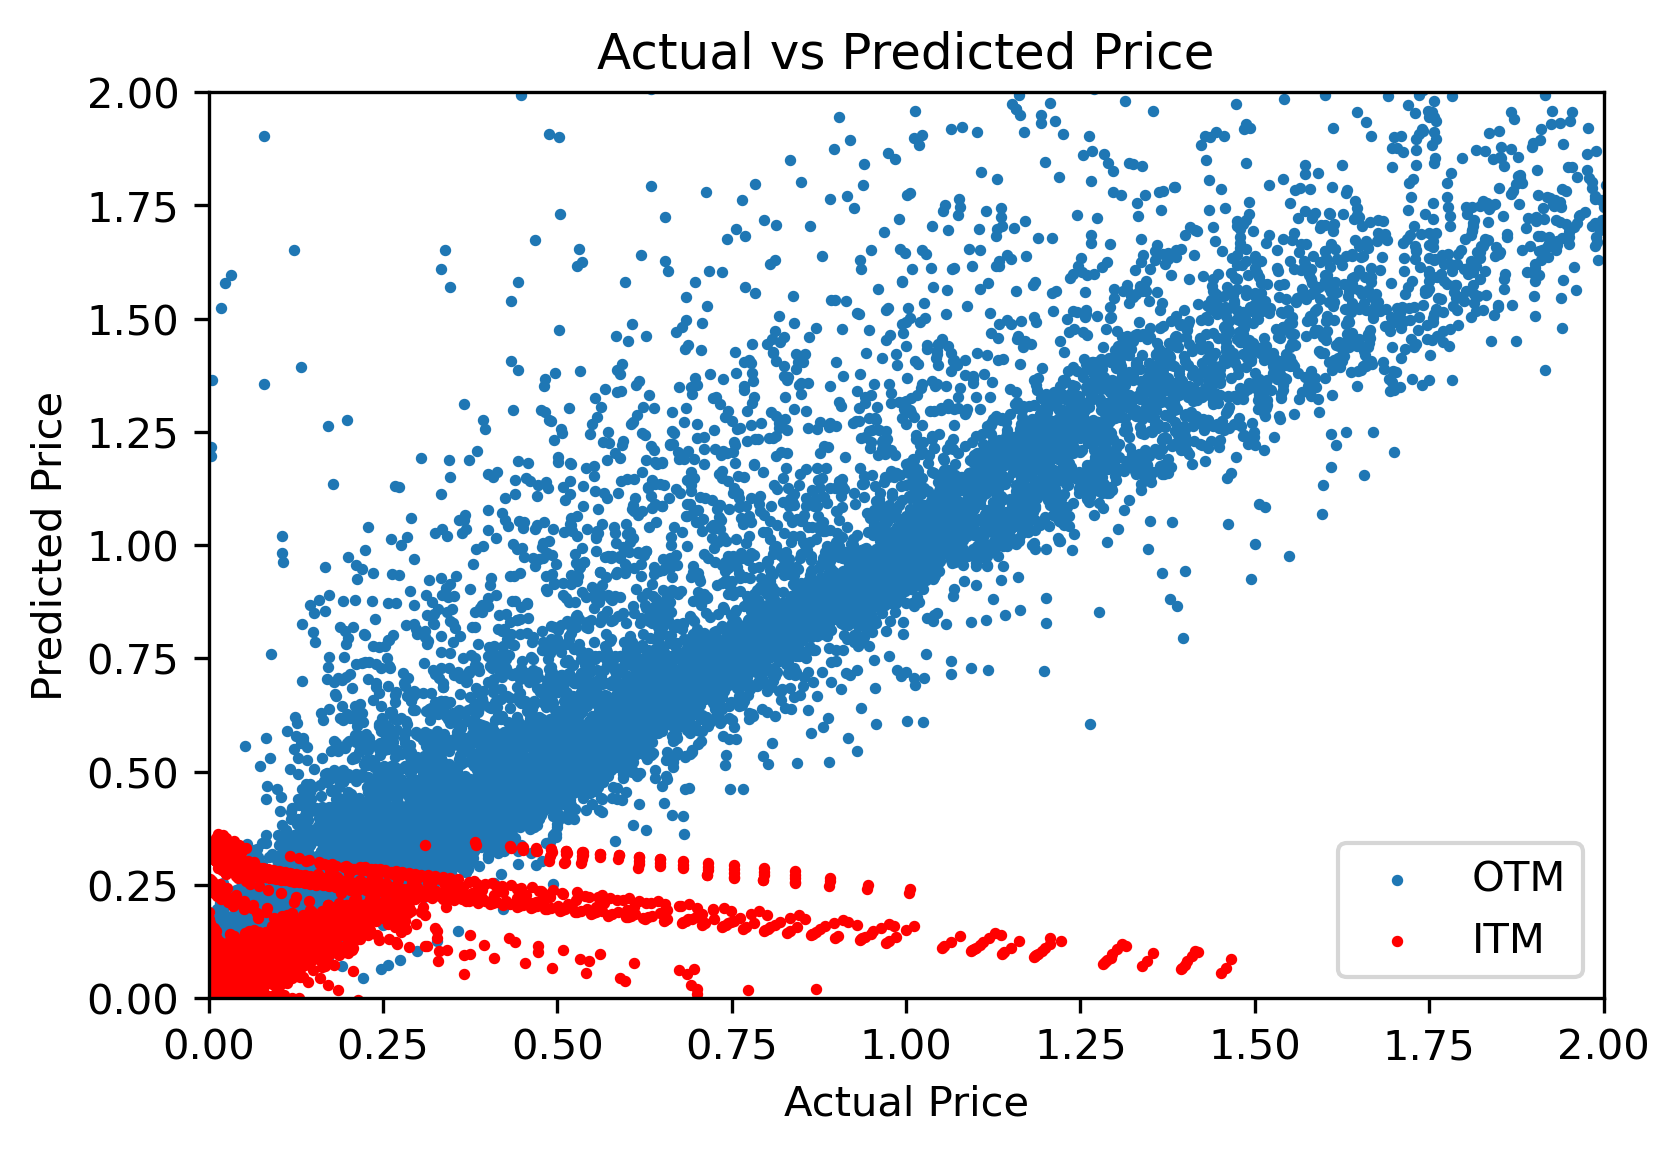

In [60]:
X_df2_itm = df2[df2['Strike Price'] < df2['Stock Price']]
X_df2_otm = df2[df2['Strike Price'] >= df2['Stock Price']] 
Y_df2_itm = X_df2_itm['Call Price']
Y_df2_otm = X_df2_otm['Call Price']
plt.scatter(Y_df2_itm, mlp2.predict(X_df2_itm.drop('Call Price', axis=1)), s=3)
plt.scatter(Y_df2_otm, mlp2.predict(X_df2_otm.drop('Call Price', axis=1)), c='r', s=3)
plt.ylabel("Predicted Price")
plt.xlabel("Actual Price")
plt.title("Actual vs Predicted Price")
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.legend(['OTM', 'ITM'])
plt.show()

Interestingly, we see a quite similar behavior to the model trained on synthetic (yet less noisy) data. Since we are only looking at portion of the SNP and UKX data, something worth exploring would be to scrape all of the SNP data and test the model again. 

Regardless, we've shown that **real options data follows somewhat closely the guidelines established by Black-Scholes**, and that in this case, training on real data is better than training on synthetic data.

## Conclusion
In this research project, we validated Culkin and Das conclusion: a machine learning field is facing a rebirth that has found applications in highly dynamic fields such as finance. Certain financial pricing schemes could be non-linear (e.g., Black-Scholes) and undergo a significant amount of calculation to reach a conclusion. However, neural networks can learn and predict non-linear behavior fairly accurately, which can be seen from a relatively high $R^2$ values of the above models. 

However, we also saw that the fitted models produced drastically different test accuracies, depending on a seed level, and that the error distributions of those models exhibited high skewedness and kurtosis. Therefore, more consistent models could be generated through optimizing hyperparameters and conducting a comprehensive data transformation process. It is also important to note that the above models failed to fit all options with different maturities and strikes. 

In theory, it is well regarded that it is nearly impossible to predict stock prices in consistent manner as the actual market is highly efficient (i.e., Efficient Market Hypothesis). Plus, a high level of noise exists in real data. Therefore, creating a model that predicts stock prices in a very consistent manner would be extremely difficult to create, yet would yield inmense monetary benefits.